In [137]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc, Ellipse
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM, radial_integral
from py4DSTEM.process.utils import fit_double_sided_gaussian, double_sided_gaussian, convert_ellipse_params
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.io import read, save, append, FileBrowser
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks, find_Bragg_disks_single_DP, find_Bragg_disks_single_DP_FK
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map, threshold_Braggpeaks
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts
from py4DSTEM.process.classification import get_class_DP

In [2]:
# Load data

fp = "/home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x.h5"
dc = py4DSTEM.file.io.read(fp) # datacube import

/home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x.h5 is a py4DSTEM file, v0.6. Reading...


### Preliminary Visualization of Data

Create an average diffraction pattern (without any shift-correction), a bright field image, and a dark field image. To do this we'll create some virtual apertures and integrate the intensity of the diffraction patterns in those aperture rings. Then we'll save these to a file to be used later.

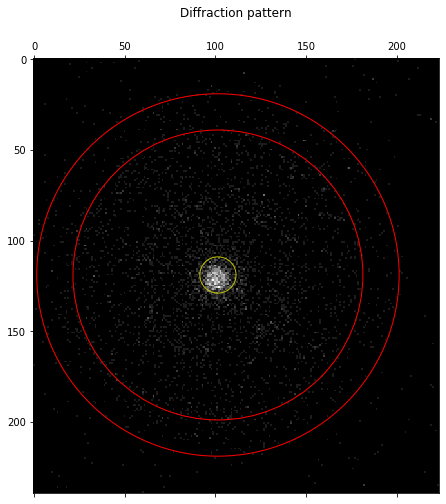

In [3]:
## Select detector positions while looking at a single diffraction pattern

BF_detector_max = 10                            # Bright Field detector in pixels from center 
ADF_detector_min, ADF_detector_max = 80,100     #  Dark Field detector in pixels from center
rx,ry = np.random.randint(0,dc.R_Nx),np.random.randint(0,dc.R_Ny)       # Scan position

DP = dc.data[rx,ry,:,:]
x0,y0 = py4DSTEM.process.utils.get_CoM(dc.data[rx,ry,:,:])

# Plot images
fig,ax = plt.subplots(figsize=[8,8])
ax.matshow(DP)
ax.set_title('Diffraction pattern', pad=20)
circle_ADF_inner = Circle((y0,x0),radius=ADF_detector_max, fill=False, edgecolor='r', linestyle="-")
circle_ADF_outer = Circle((y0,x0),radius=ADF_detector_min, fill=False, edgecolor='r', linestyle="-")
circle_BF_outer = Circle((y0,x0),radius=BF_detector_max, fill=False, edgecolor='y', linestyle="-")
ax.add_patch(circle_ADF_inner)
ax.add_patch(circle_ADF_outer)
ax.add_patch(circle_BF_outer)
plt.show()

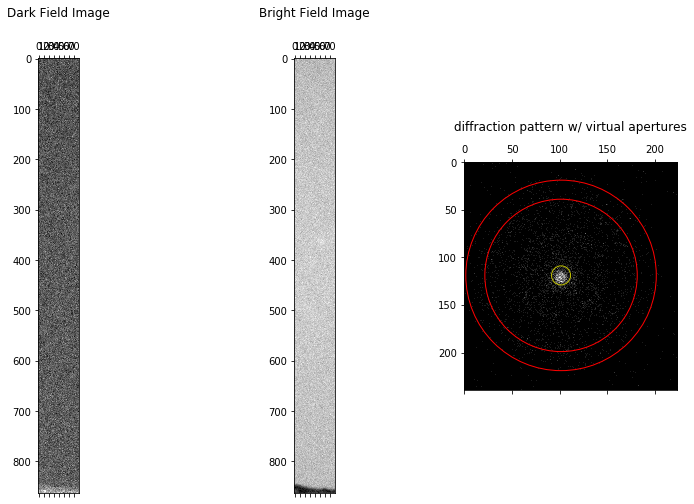

In [4]:
## Create Bright Field and Dark Field Image using Virtual Aperture 

power = 0.1    # Raise the DP intensity to a power in visualization to enhance contrast 

# Annular Images  
ADF = dc.get_virtual_image_annular_integrate((slice(int(x0)-ADF_detector_max,int(x0)+ADF_detector_max)),
                                             (slice(int(y0)-ADF_detector_max,int(y0)+ADF_detector_max)),
                                                    ADF_detector_max/ADF_detector_min)[0]
BF = dc.get_virtual_image_circ_integrate((slice(int(x0)-BF_detector_max,int(x0)+BF_detector_max)),
                                             (slice(int(y0)-BF_detector_max,int(y0)+BF_detector_max)))[0]

# Plot images
fig,axs = plt.subplots(1,3,figsize=[13,8])
axs[0].matshow(ADF)
axs[0].set_title('Dark Field Image', pad=20)
axs[1].matshow(BF)
axs[1].set_title('Bright Field Image', pad=20)
axs[2].matshow(DP)
circle_ADF_inner = Circle((y0,x0),radius=ADF_detector_max, fill=False, edgecolor='r', linestyle="-")
circle_ADF_outer = Circle((y0,x0),radius=ADF_detector_min, fill=False, edgecolor='r', linestyle="-")
circle_BF_outer = Circle((y0,x0),radius=BF_detector_max, fill=False, edgecolor='y', linestyle="-")
axs[2].add_patch(circle_ADF_inner)
axs[2].add_patch(circle_ADF_outer)
axs[2].add_patch(circle_BF_outer)
axs[2].set_title('diffraction pattern w/ virtual apertures', pad=20)
plt.show()

In [184]:
# Store images as Realslices 
virtual_images_data = np.empty((dc.R_Nx,dc.R_Ny,2))
virtual_images_data[:,:,0] = ADF
virtual_images_data[:,:,1] = BF

virtual_images = py4DSTEM.file.datastructure.RealSlice(virtual_images_data,
                                                       name='virtual_images',
                                                       slicelabels=('ADF','BF'))

### Create a Vacuum Probe

A vacuum probe is used as a template to match/find the disk positions. Here we'll use it to find our center disks.  py4DSTEM supports 3 methods of vacuum probe extraction - from a vacuum scan, from a vacuum region, and synthetically.  Here, we'll get a vacuum probe from a vacuum region of our scan.  For more examples, see module_demos/braggdiskdetection/probetemplate.ipynb.

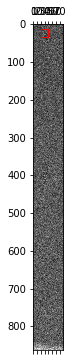

In [17]:
# Select a Region of Interest using max and min x and y values 

xmin,xmax=14, 34
ymin,ymax=20,40

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(ADF,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

In [7]:
# Get average, shift-corrected probe from ROI
# This step can take a little time, as shift correction requires taking FFTs

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3 
verbose = False

probe = get_average_probe_from_ROI(dc, ROI=ROI, 
                                       mask_threshold=mask_threshold, 
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

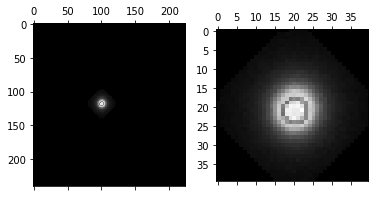

In [8]:
# Show average probe
# The probe has an apparent dark ring around it, this is an artifact of the electron counting performed on this data set 

rad = 20                              # for zoomed-in display 
xCoM_init,yCoM_init = get_CoM(probe) # Getting the center of mass of the probe

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

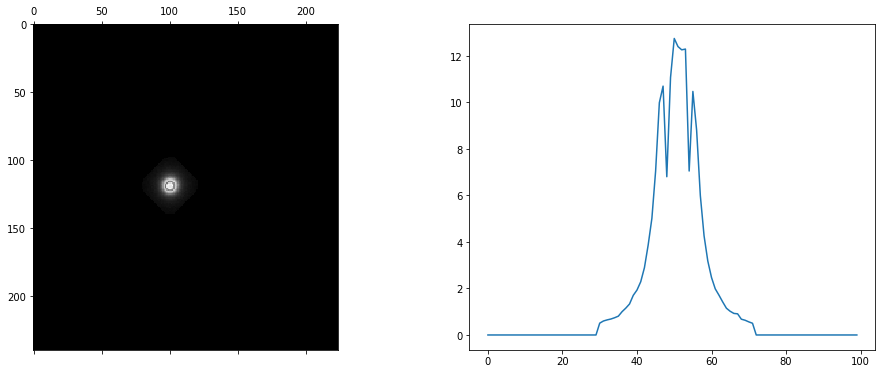

In [9]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length= 50

line_profile = np.sum(probe[int(xCoM_init)-lineprofile_length:int(xCoM_init)+lineprofile_length,int(yCoM_init)-1:int(yCoM_init)+1],axis=(1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
ax1.matshow(probe)
ax2.plot(np.arange(len(line_profile)),line_profile)
plt.show()

In [10]:
# Make probe kernel

sigma_probe_scale=3

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

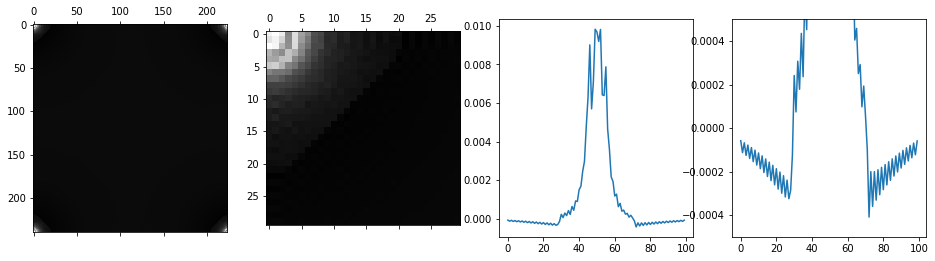

In [11]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length= 50
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Finding Center Disk Location 

### Test parameters on a few diffraction patterns

In the cell below, we detect the Bragg disk positions in just a few diffraction patterns.  This is because the full calculation can be quite slow, so selecting just a few DPs allows us to quickly test parameters to figure out how best to locate the peaks.  It is worth taking your time at this step!

First, choose 3 scan positions to test.  I typically choose a very clean diffraction pattern, a very noisy one, and something in between.

#### **Understanding and Setting the User Input Parameters**
1. **CorrPower**: the cross correlation power. A value of 1 corresponds to a cross correaltion, and 0 corresponds to a phase correlation, with intermediate values giving various hybrids.

2. **sigma**: standard deviation for guassian smoothing applied to cross-correlation

3. **edgeBoundary**: distance in pixels from the diffraction pattern edge, defines how much of the pattern will be used in the correlation 

4. **maxNumPeaks**: maximum number of peaks that will be identified (10 is usually good, but you should view a single DP to get an idea for this setting)

5. **minPeakSpacing**: the minimum number of pixels between peaks (guards against identifying a single peak as multiple)

6. **minRelativeIntensity**: scaling factor used to determine minimum intensity that can be considered a peak - if (minRelativeIntensity*[max intensity of the DP]) < Peak Intensity this will not be considered a peak -

7. **subpixel**: subpixel fitting settings - 'poly': polynomial interpolation of correlogram peaks (fairly fast but not very accurate)'multicorr': uses the multicorr algorithm with DFT upsampling

We are only interested in the center disk, so to speed up the calculation we'll set the edge boundary very large as to only detect disks near the centers of the patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


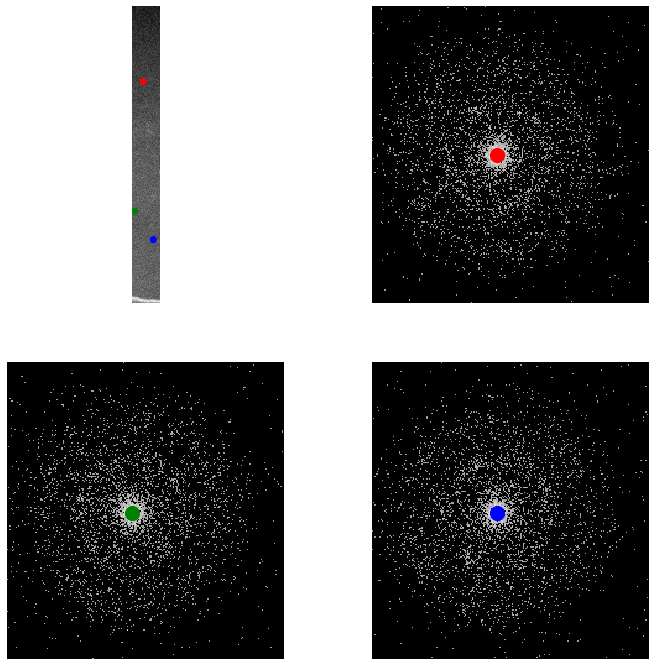

In [12]:
######## Parameters ########

# Select scan positions
Rxs = np.random.randint(0,dc.R_Nx, size =3)
Rys = np.random.randint(0,dc.R_Ny, size =3)  

# Peak detection parameters
corrPower = 1
sigma = 2
edgeBoundary = 70 
maxNumPeaks = 1
minPeakSpacing = 2
minRelativeIntensity = 0.03
subpixel = 'poly'


# Display parameters
power = 0.2    # To increase the contrast in the pattern we raise it to a power between 0 and 1
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns
 Perform disk detection on entire data set. Since we're only interested in the central disk, we'll use the center detected above to crop down the area in which we are detecting disks in our patterns and increase the speed of detection. 

In [13]:
# Find Center Disks in Entire Data Set 
braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzed 69120 diffraction patterns in 0h 9m 12s


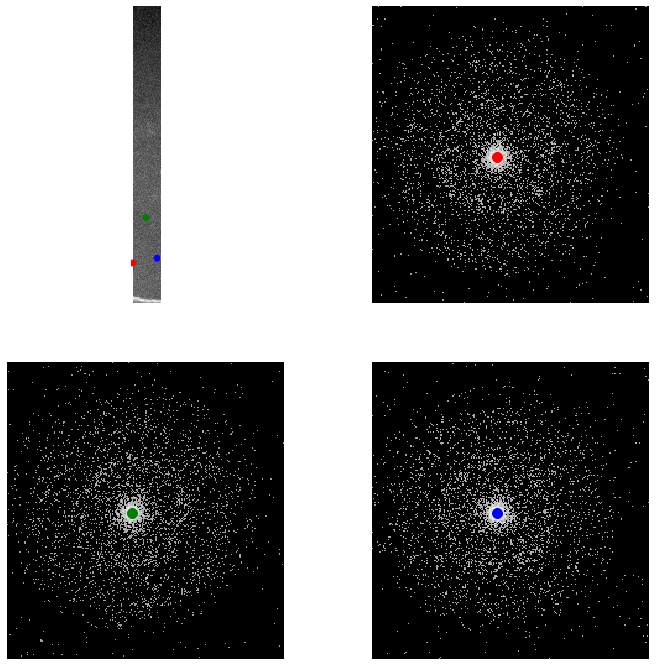

In [18]:
# Show results for a few DPs

xs = np.random.randint(0,dc.R_Nx, size =3)
ys = np.random.randint(0,dc.R_Ny, size =3)  

power=0.2

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

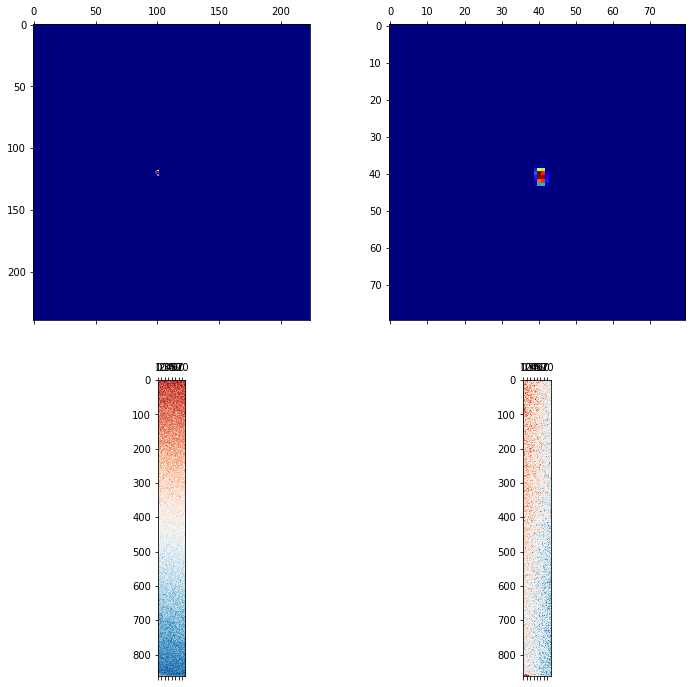

In [24]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks,
                                                                 dc.Q_Nx, dc.Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**0.25,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

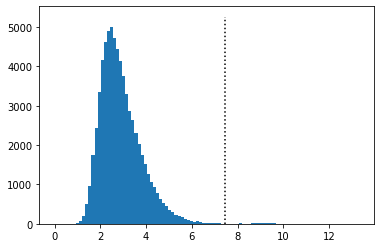

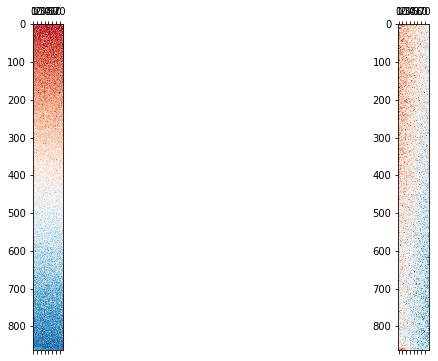

In [26]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

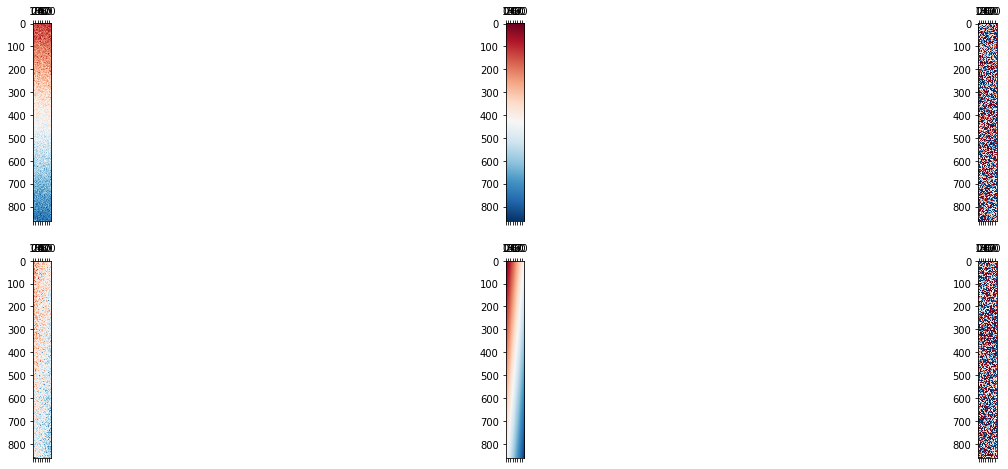

In [33]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,8))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

### Selecting a Region to Perform RDF

RDF analysis is good at revealing local variation in short or medium range order. Here, we will select a ROI and create an average diffraction pattern from that area which we will then perform RDF on. 

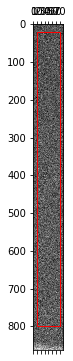

In [85]:
# Select a Region of Interest using max and min x and y values 

xmin,xmax=20,800
ymin,ymax=10,70

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(ADF,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

In [36]:
# Get average DP

aveDP = get_class_DP(dc, ROI, xshifts=xshifts_fit, yshifts=yshifts_fit)

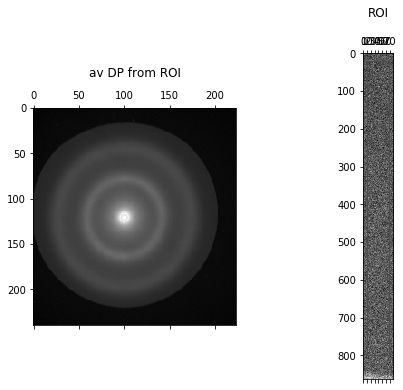

In [86]:
# Show

power = 0.2

fig,axs = plt.subplots(1,2, figsize=[8,6])
axs[0].matshow(aveDP**power)
axs[0].set_title('av DP from ROI', pad =20)
axs[1].matshow(ADF)
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')
axs[1].add_patch(roi_rect)
axs[1].set_title('ROI', pad =20)
plt.show()

In [88]:
# Save as py4DSTEM dataobjects

avg_DP_ROI = py4DSTEM.file.datastructure.DiffractionSlice(aveDP, name='avg_DP_ROI')

coordinates = [('xmin', 'float64'), ('xmax', 'float64'), ('ymin', 'float64'), ('ymax', 'float64'), 
               ('qx_center', 'float64'), ('qy_center','float64')]
ROI_pointlist = PointList(coordinates = coordinates, name = 'ROI')
ROI_selected = np.asarray([xmin, xmax, ymin, ymax, x0, y0])
ROI_selected = ROI_selected.astype(float)
ROI_pointlist.add_point(ROI_selected)

### Pixel Size Callibration 

At the bottom of our scan there is a crystalline region. We will use the crystalline diffraction patterns as a standard to callibrate our data. First let's take a look at these patterns.

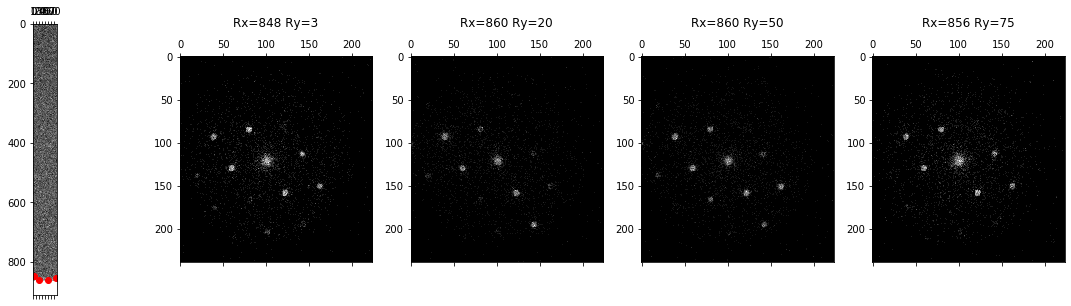

In [66]:
# Visualize a few diffraction patterns in the crystalline region

Rx, Ry = [848,860,860,856], [3,20,50,75]
fig,axs = plt.subplots(1,len(Rx)+1, figsize = [5*len(Rx),5])
axs[0].matshow(ADF)
axs[0].scatter(Ry,Rx, color ='r')
for r in range(len(Rx)):
    axs[r+1].matshow(dc.data[Rx[r], Ry[r],:,:])
    axs[r+1].set_title('Rx='+str(Rx[r])+' Ry='+str(Ry[r]), pad = 20)

plt.show()

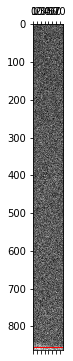

In [67]:
# Make an average diffraction pattern from this region 

xmin,xmax=856,dc.R_Nx
ymin,ymax=0,dc.R_Ny

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(ADF,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

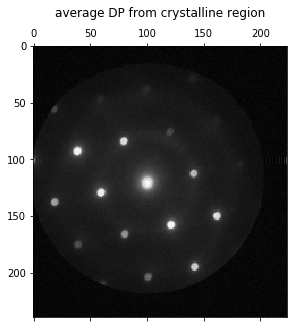

In [73]:
# Get average DP

power = 0.5

aveDP_crystalline = get_class_DP(dc, ROI, xshifts=xshifts_fit, yshifts=yshifts_fit)
aveDP_crystalline[aveDP_crystalline<0]=0

# Show
fig,ax = plt.subplots(figsize= [5,5])
ax.matshow(aveDP_crystalline**power)
ax.set_title('average DP from crystalline region', pad=15)
plt.show()

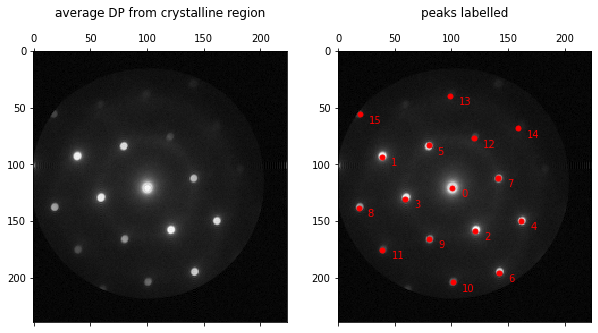

In [75]:
# Locate the bragg peaks in our average crystalline DP

corrPower = 1 # cross correlation 
sigma = 2
edgeBoundary = 10
maxNumPeaks = 20
minPeakSpacing = 2
minRelativeIntensity = 0.005
subpixel = 'multicorr'
upsample_factor = 16

crystal_peaks = find_Bragg_disks_single_DP(aveDP_crystalline, probe_kernel,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel,
                                  upsample_factor=upsample_factor)

# Let's take a look at our peaks and average diffraction pattern
power = 0.5
labels = np.arange(0,crystal_peaks.data['qy'].shape[0])
fig, ax = plt.subplots(1,2, figsize= [10,5])
ax[0].matshow(aveDP_crystalline**power)
ax[0].set_title('average DP from crystalline region', pad = 20)
ax[1].matshow(aveDP_crystalline**power)
ax[1].set_title('peaks labelled', pad = 20)
ax[1].scatter(crystal_peaks.data['qy'], crystal_peaks.data['qx'], color = 'r', s=25) 
for i in range(labels.shape[0]):
    ax[1].annotate(str(labels[i]), (crystal_peaks.data['qy'][i]+8, crystal_peaks.data['qx'][i]+8), color ='r')

plt.show()

angle= 55.16  ratio= 0.869  flipped ratio= 1.151


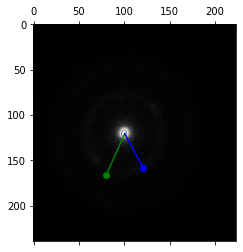

In [76]:
# Distances from center peak
qr = np.sqrt((crystal_peaks.data['qx'][1::]-crystal_peaks.data['qx'][0])**2+(crystal_peaks.data['qy'][1::]-crystal_peaks.data['qy'][0])**2)

# Angles between chosen peaks
pk = [2,9]
pk1 = np.array([(crystal_peaks.data['qx'][0]-crystal_peaks.data['qx'][pk[0]]), (crystal_peaks.data['qy'][0]-crystal_peaks.data['qy'][pk[0]])])
pk2 = np.array([(crystal_peaks.data['qx'][pk[1]]-crystal_peaks.data['qx'][0]), (crystal_peaks.data['qy'][pk[1]]-crystal_peaks.data['qy'][0])])
dthet = np.degrees((np.dot(pk1,pk2))/(np.sqrt(pk1.dot(pk1))*np.sqrt(pk2.dot(pk2))))

ratio = qr[pk[0]-1]/qr[pk[1]-1]

fig, ax = plt.subplots(1,1)
ax.matshow(avDP_crystalline)
ax.scatter(crystal_peaks.data['qy'][pk[0]], crystal_peaks.data['qx'][pk[0]], color = 'b')
ax.scatter(crystal_peaks.data['qy'][pk[1]], crystal_peaks.data['qx'][pk[1]], color = 'g')
ax.plot([crystal_peaks.data['qy'][0], crystal_peaks.data['qy'][pk[1]]],[crystal_peaks.data['qx'][0], crystal_peaks.data['qx'][pk[1]]], color = 'g')
ax.plot([crystal_peaks.data['qy'][0], crystal_peaks.data['qy'][pk[0]]],[crystal_peaks.data['qx'][0], crystal_peaks.data['qx'][pk[0]]], color = 'b')
print('angle=', np.round(dthet,3)+90, ' ratio=', np.round(ratio,3), ' flipped ratio=',np.round(1/ratio,3) )

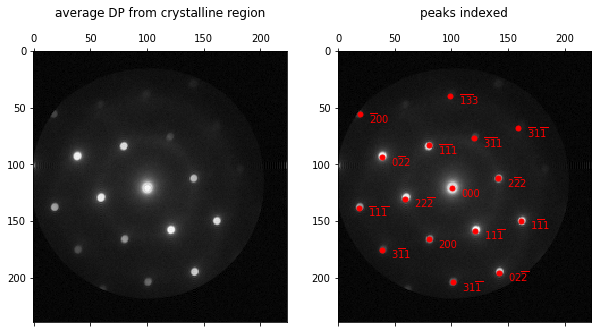

In [78]:
# Based on the angles and ratios, this is assigned as the [011] Zone Axis of Silicon 
# Now let's index those peaks 
labels = ['000', '0'+ r'$\overline{2}$'+'2', '11'+ r'$\overline{1}$', '22'+r'$\overline{2}$', '1'+ r'$\overline{1}$'+'1', r'$\overline{1}$'+r'$\overline{1}$'+'1', '02'+r'$\overline{2}$', 
         '2'+r'$\overline{2}$'+'2', r'$\overline{1}$'+'1'+r'$\overline{1}$', '200', '31'+r'$\overline{1}$', '3'+r'$\overline{1}$'+'1', r'$\overline{3}$'+r'$\overline{1}$'+'1', 
          r'$\overline{1}$'+r'$\overline{3}$'+'3',  r'$\overline{3}$'+'1'+r'$\overline{1}$', r'$\overline{2}$'+'0'+'0']
power = 0.5
fig, ax = plt.subplots(1,2, figsize= [10,5])
ax[0].matshow(aveDP_crystalline**power)
ax[0].set_title('average DP from crystalline region', pad = 20)
ax[1].matshow(aveDP_crystalline**power)
ax[1].set_title('peaks indexed', pad = 20)
ax[1].scatter(crystal_peaks.data['qy'], crystal_peaks.data['qx'], color = 'r', s= 25) 
for i in range(len(labels)):
    ax[1].annotate(labels[i], (crystal_peaks.data['qy'][i]+8, crystal_peaks.data['qx'][i]+8), color ='r', fontsize= 10)

plt.show()

In [79]:
# Assigned Indices Above
indices = np.array(
         [0,-2, 2, 
         1,1,-1,
         2,2,-2,
         1,-1,1,
         -1,-1,1,
         0,2,-2, 
         2,-2,2,
         -1,1,-1,
         2,0,0,
         3,1,-1,
         3,-1,1, 
         -3,-1,1,
         -1,-3,3,
         -3,1,-1,
         -2,0,0]).reshape(15,3)

# Silicon Lattice Parameter
a= 5.431020511 # Angstroms 

# Calculated Distances
d= a/np.sqrt(np.sum(indices**2, axis = 1))

# Distances of detected disks from center peak
qr = np.sqrt((crystal_peaks.data['qx'][1::]-crystal_peaks.data['qx'][0])**2+(crystal_peaks.data['qy'][1::]-crystal_peaks.data['qy'][0])**2)

# Callibrating Pixel Size 
dq = np.mean((1/(qr*d)))

In [82]:
# Saving the scale into a py4DSTEM format
coordinates = [('dq', 'float64')]
scale = PointList(coordinates = coordinates, name = 'dq')
dq = np.asarray([dq])
dq = dq.astype(float)
scale.add_point(dq)

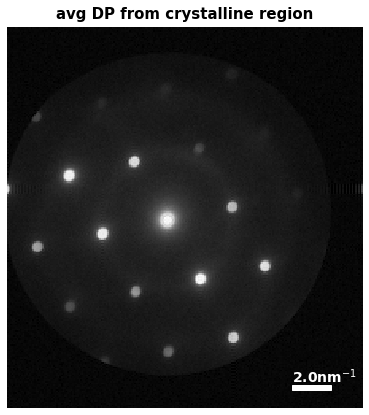

In [84]:
# Plot the diffraction pattern with a scalebar 
scalebar_location = [dc.Q_Ny-dc.Q_Ny/5, dc.Q_Nx-dc.Q_Ny/15]
scalebar_size = [2/(10*dq),3]
scalebar_label = str(np.round(dq*10*scalebar_size[0],0)[0])+'nm'+'$^{-1}$'
scalebar_color = 'w'

fig, ax = plt.subplots(1,1, figsize= [7,7])
ax.matshow(aveDP_crystalline**power)
ax.set_title('avg DP from crystalline region', pad = -10, fontweight= 'bold', fontsize = 15)
scalebar = Rectangle((scalebar_location[0],scalebar_location[1]), scalebar_size[0],scalebar_size[1], color=scalebar_color)
ax.add_patch(scalebar)
ax.text(x=scalebar_location[0], y =scalebar_location[1]-(scalebar_size[1]/2), s=scalebar_label, fontweight='bold', fontsize= 14, color = scalebar_color)
ax.axis('off')

plt.show()

### Elliptical calibration

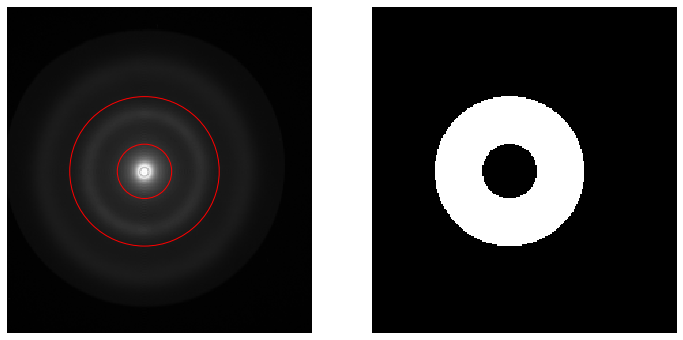

In [175]:
# Make a mask

r_inner = 20
r_outer = 55

yy,xx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
rr = np.hypot(xx-x0,yy-y0)
mask = (rr>r_inner)*(rr<=r_outer)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(aveDP**power)
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax1.add_patch(circle_inner)
ax1.add_patch(circle_outer)
ax2.matshow(mask)
ax1.axis('off')
ax2.axis('off')
plt.show()

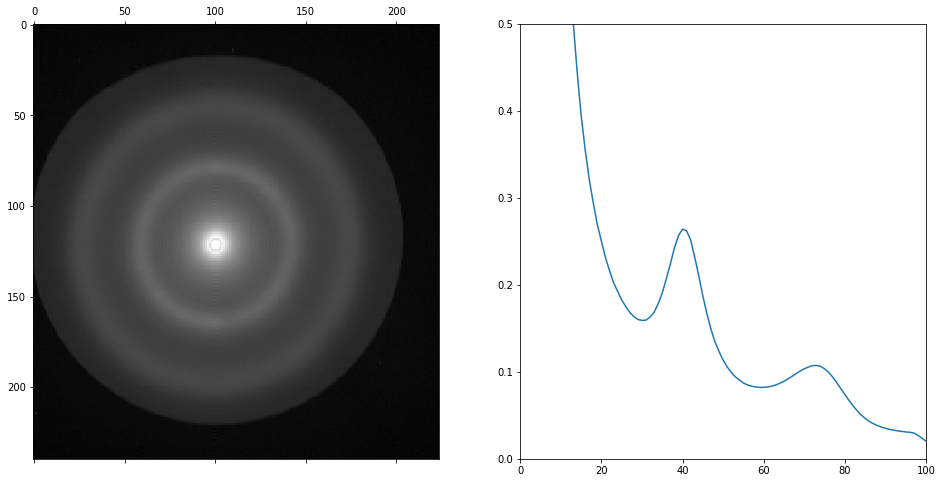

In [176]:
# Show average DP with radial profile

power = 0.2

radial_profile = radial_integral(aveDP, x0,y0)[0]

fig,axs = plt.subplots(1,2,figsize=[16,8])
axs[0].matshow(aveDP**power)
axs[1].plot(np.arange(len(radial_profile)),radial_profile)
axs[1].set_ylim(0,0.5)
axs[1].set_xlim(0,100)
plt.show()

In [177]:
# Fit a double-sided guassian

I0 = np.max(aveDP)
I1 = 0.28
sigma0 = 20
sigma1 = 10
sigma2 = 10
c_bkgd = 0
R = 40
x0 = x0
y0 = y0
A = 1
B = 0
C = 1

p0 = (I0,I1,sigma0,sigma1,sigma2,c_bkgd,R,x0,y0,A,B,C)
dsg_params = fit_double_sided_gaussian(aveDP, p0, mask=mask)

A,B,phi = convert_ellipse_params(dsg_params[9],dsg_params[10],dsg_params[11])
x0,y0 = dsg_params[7:9]
R = dsg_params[6]

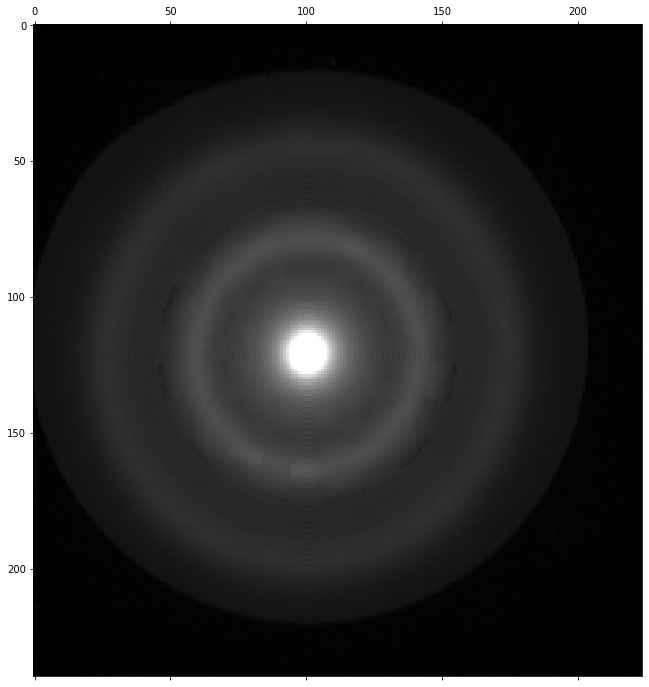

In [178]:
# display results
# colin-style visualization

power=0.5
# r_inner = 200
# r_outer = 350
N_pinwheel = 24  # Even number

# Make coords
yy,xx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
x,y = xx-x0,yy-y0
r = np.hypot(x,y)
r2 = r**2
theta = np.arctan2(y,x)

# Make mask
thetas = np.linspace(-np.pi,np.pi,N_pinwheel)
pinwheel = np.zeros((dc.Q_Nx,dc.Q_Ny))
for i in range(len(thetas[::2])):
    pinwheel += (theta<thetas[1::2][i]) * (theta>=thetas[::2][i])
mask = pinwheel * (r>r_inner) * (r<=r_outer)

# Get fit
fit = double_sided_gaussian(dsg_params,xx,yy)

data_ma = np.ma.array(data=aveDP, mask=mask)
fit_ma = np.ma.array(data=fit, mask=mask==False)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data_ma**power,vmin=np.min(data_ma**power),vmax=0.6*np.max(data_ma**power))
ax.matshow(fit_ma**power,vmin=np.min(data_ma**power),vmax=0.6*np.max(data_ma**power))
plt.show()

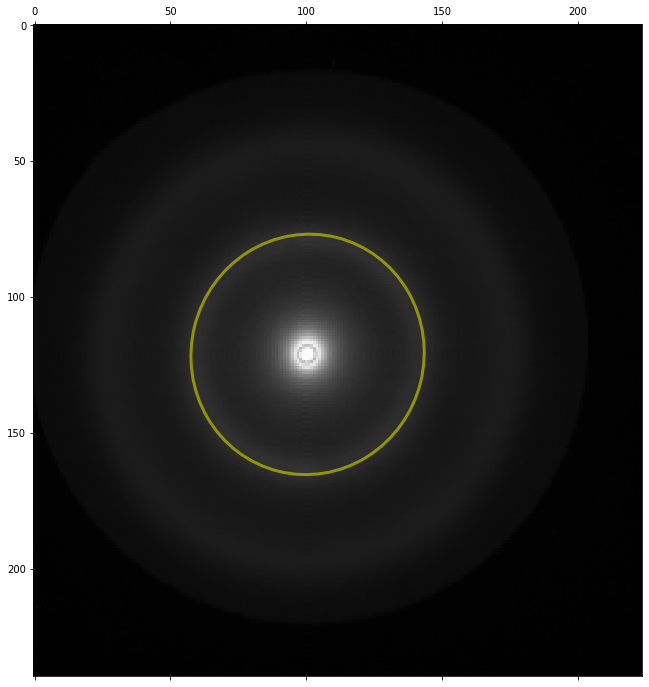

Measured elliptical stretch: 3.35%


In [181]:
# Show ellipse

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(aveDP**power,vmin=np.min(aveDP**power),vmax=np.max(aveDP**power))
ellipse = Ellipse((y0,x0),2*R*A,2*R*B,90-np.degrees(phi), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical stretch: {:.2f}%".format(100*(1-B/A)))

In [182]:
# Store ellipse params

ellipse_params = py4DSTEM.file.datastructure.PointList(
                        coordinates=[('x0',float),('y0',float),('A',float),('B',float),('phi',float)],
                        name='ellipse_params')
ellipse_params.add_point((x0,y0,A,B,phi))

### Save

In [89]:
data_objects = [braggpeaks, virtual_images, avg_DP_ROI, ROI_pointlist, scale, ellipse_params]

In [90]:
savepath = "/home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x_processing.h5"
save(data_objects, savepath)

Creating file /home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x_processing.h5...
Done.


In [186]:
py4DSTEM.file.io.append(virtual_images,savepath)

Opening file /home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x_processing.h5...
Done.


In [189]:
py4DSTEM.file.io.show_dataobjects(savepath)

 Index                  Name                        Type        
   0    avg_DP_ROI                          DiffractionSlice    
   1    virtual_images                      RealSlice           
   2    ROI                                 PointList           
   3    dq                                  PointList           
   4    ellipse_params                      PointList           
   5    braggpeaks                          PointListArray      


In [188]:
py4DSTEM.file.io.remove(1,savepath)

Opening file /home/ben/Data/20191220_alphaSi_JennDonohue_rdf/alpha-Si-counted-bin8x_processing.h5...
Done.
